<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#K臂老虎机和强化学习" data-toc-modified-id="K臂老虎机和强化学习-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>K臂老虎机和强化学习</a></span><ul class="toc-item"><li><span><a href="#K臂老虎机" data-toc-modified-id="K臂老虎机-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>K臂老虎机</a></span></li><li><span><a href="#学习器‘基类’" data-toc-modified-id="学习器‘基类’-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>学习器‘基类’</a></span></li><li><span><a href="#$\epsilon$-贪心" data-toc-modified-id="$\epsilon$-贪心-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>$\epsilon$-贪心</a></span></li><li><span><a href="#只利用" data-toc-modified-id="只利用-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>只利用</a></span></li><li><span><a href="#softmax法" data-toc-modified-id="softmax法-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>softmax法</a></span></li></ul></li><li><span><a href="#不同方法的比较" data-toc-modified-id="不同方法的比较-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>不同方法的比较</a></span></li></ul></div>

# K臂老虎机和强化学习

## K臂老虎机

In [1]:
import numba
import numpy as np
def _trival(f):
    return f
_dec = numba.njit
#_dec = _trival

# K bandits maker
# return: K bandits data structure
@_dec
def initialize_KBandits(P, R):
    return P, R

# roll K bandits
#   self: the K bandits data
#      k: the kth hand
# return: the score
@_dec
def roll_KBandits(self, k):
    P,R = self
    
    rnd = np.random.rand()
    if rnd < P[k]:
        return R[k]
    else:
        return 0.

## 学习器‘基类’

In [2]:

@_dec
def initialize_BaseLearner(K):
    """
    base leaner data structure
          K: number of hands
    return: leaner data structure
    """
    Q =  np.zeros(K)
    n = np.zeros(K)
    tot =  np.zeros(1)
    return K, Q, n, tot

@_dec
def update_BaseLearner(self, which, v):
    K,Q,n,tot = self
    q = Q[which]
    n[which] += 1
    Q[which] += (v - q)/n[which]
    tot[0] += v
    
@_dec
def get_average_score_BaseLearner(self):
    K,Q,n,tot = self
    return tot[0]/n.sum()
    

## $\epsilon$-贪心

In [3]:

    
@_dec
def intialize_EpsilonGreedyLearner(K, epsilon, n_half=np.inf):
    base = initialize_BaseLearner(K)
    return base, epsilon, n_half
    
    

@_dec
def next_try_EpsilonGreedyLearner(self):
    base, epsilon, n_half = self
    K, Q, n, tot = base
    rnd = np.random.rand()

    if rnd <= epsilon*np.sqrt( 1/(1+n.sum()/n_half) ):
        # exploration 
        k = np.random.randint(K)
    else:
        # exploitation
        rmax = np.max(Q)
        # collect the indices of maximum values
        indices = np.nonzero(Q == rmax)[0]
        # select randomly from the indices
        k = indices[np.random.randint(len(indices))]
    return k
    

## 只利用

In [4]:
@_dec
def initialize_ExploitationOnlyLearner(K):
    base = initialize_BaseLearner(K)
    return (base,)

@_dec
def next_try_ExploitationOnlyLearner(self):
    base, = self
    K, Q, n, tot = base
    
    if tot[0] > 0:
        k = np.argmax(Q)
    else:
        k = np.random.randint(K)
    return k
    

## softmax法

In [5]:

@_dec
def intialize_SoftmaxKBLearn(K, tau):
    base = initialize_BaseLearner(K)
    return base, tau
  
    
@_dec
def next_try_SoftmaxKBLearn(self):
    base, tau = self
    K, Q, n, tot = base
    
    
    qmax = np.max(Q)
    p = np.exp((Q-qmax)/tau)
    p *= 1/p.sum()    
    p = np.cumsum(p)

    rnd = np.random.rand(1)[0]
    for k in range(K):
        if rnd <= p[k]:
            break                
    return k

# 不同方法的比较

In [10]:
import matplotlib.pyplot as plt

@_dec
def simulate(K, N, P, R):
    
    np.random.seed(0)
    
    results=np.zeros((7, 1000, N))    
    
    kb = initialize_KBandits(P, R)
    
    for r in range(3):
        
        epsilon = 0.0
        
        if r == 0:
            epsilon = 1.0
        elif r == 1:
            epsilon = 0.01
        elif r == 2:
            epsilon = 0.1
            
        
        for i in range(1000):
            epsilongreedy = intialize_EpsilonGreedyLearner(K, epsilon)
            for n in range(N):
                
                k = next_try_EpsilonGreedyLearner(epsilongreedy)
                v = roll_KBandits(kb, k)
                update_BaseLearner(epsilongreedy[0], k, v)                
                results[r, i, n] = get_average_score_BaseLearner(epsilongreedy[0])
                

    for i in range(1000):
        exploitationonly = initialize_ExploitationOnlyLearner(K)
        for n in range(N):

            k = next_try_ExploitationOnlyLearner(exploitationonly)
            v = roll_KBandits(kb, k)
            update_BaseLearner(exploitationonly[0], k, v)                
            results[3, i, n] = get_average_score_BaseLearner(exploitationonly[0])
    
                
    for r in range(4,6):
        
        tau = 0.
        if r == 4:
            tau = 0.01
        else:
            tau = 0.1
                    
        for i in range(1000):
            softmax = intialize_SoftmaxKBLearn(K, tau)
            for n in range(N):
                
                k = next_try_SoftmaxKBLearn(softmax)
                v = roll_KBandits(kb, k)
                update_BaseLearner(softmax[0], k, v)       
                results[r, i, n] = get_average_score_BaseLearner(softmax[0])           
                
                
    for i in range(1000):
        epsilongreedy = intialize_EpsilonGreedyLearner(K, 0.1, n_half=50)
        for n in range(N):

            k = next_try_EpsilonGreedyLearner(epsilongreedy)
            v = roll_KBandits(kb, k)
            update_BaseLearner(epsilongreedy[0], k, v)                
            results[6, i, n] = get_average_score_BaseLearner(epsilongreedy[0])

    return results

K = 2
N=3000
P=np.array([0.4, 0.2])
R=np.ones(K)
results = simulate(K=K, N=N, P=P, R=R)
results = np.mean(results, axis=1)

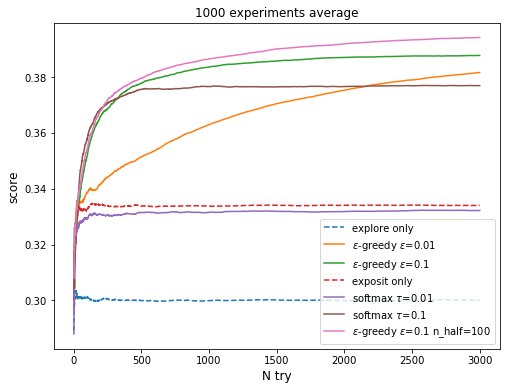

In [17]:
def show():
            
    plt.figure(figsize=(8,6))
    plt.title("1000 experiments average")
    plt.plot(np.linspace(1,N,N), results[0,:], label=r"explore only", linestyle="--")
    plt.plot(np.linspace(1,N,N), results[1,:], label=r"$\epsilon$-greedy $\epsilon$=0.01")
    plt.plot(np.linspace(1,N,N), results[2,:], label=r"$\epsilon$-greedy $\epsilon$=0.1")
    plt.plot(np.linspace(1,N,N), results[3,:], label=r"exposit only", linestyle="--")
    plt.plot(np.linspace(1,N,N), results[4,:], label=r"softmax $\tau$=0.01")
    plt.plot(np.linspace(1,N,N), results[5,:], label=r"softmax $\tau$=0.1")
    plt.plot(np.linspace(1,N,N), results[6,:], label=r"$\epsilon$-greedy $\epsilon$=0.1 n_half=100")
    
    plt.ylabel("score", fontsize="large")
    plt.xlabel("N try", fontsize="large")
    plt.legend()
    plt.show()
            
show()